In [1]:
from astropy.io import fits
import numpy as np
import astropy.units as u
import astropy.constants as const


In [2]:
filename = 'cube_zodi1inc0dist3_epoch25.7300_sres150.000_0.6um.fits'
cube = fits.open(filename)[0].data

maxlam = 1.2
minlam = 0.6
R = 150
dlam = (maxlam+minlam)/2./R
lamlist = np.arange(minlam,maxlam,dlam)
dist_pc = 3
pix_scale_au = 0.057*dist_pc/4
asec_per_pix = pix_scale_au/dist_pc
res_asec = 0.057
OWA_880 = 0.076*20
OWA_pix = OWA_880/asec_per_pix


In [3]:
cube = cube*u.Jy

In [4]:
minlam661 = (0.661-0.061/2.)*u.micron
maxlam661 = (0.661+0.061/2.)*u.micron
minlam721 = (0.721-0.036/2.)*u.micron
maxlam721 = (0.721+0.036/2.)*u.micron
minlam890 = (0.890-0.0445/2.)*u.micron
maxlam890 = (0.890+0.0445/2.)*u.micron
F661 = cube[np.where((lamlist>minlam661.value)*(lamlist<maxlam661.value))[0],:,:]
F721 = cube[np.where((lamlist>minlam721.value)*(lamlist<maxlam721.value))[0],:,:]
F890 = cube[np.where((lamlist>minlam890.value)*(lamlist<maxlam890.value))[0],:,:]
F661_flat = np.mean(F661,axis=0)
F721_flat = np.mean(F721,axis=0)
F890_flat = np.mean(F890,axis=0)

### Crop image and convert to photons per second    

In [5]:

xdim,ydim = F661_flat.shape
print (xdim,ydim)
xmin = xdim/2-OWA_pix
xmax = xdim/2+OWA_pix
ymin = ydim/2-OWA_pix
ymax = ydim/2+OWA_pix
F661 = F661_flat[xmin:xmax,ymin:ymax]
F721 = F721_flat[xmin:xmax,ymin:ymax]
F890 = F890_flat[xmin:xmax,ymin:ymax]


dnu661 = (const.c/minlam661).to(u.Hz) - (const.c/maxlam661).to(u.Hz)
dnu721 = (const.c/minlam721).to(u.Hz) - (const.c/maxlam721).to(u.Hz)
dnu890 = (const.c/minlam890).to(u.Hz) - (const.c/maxlam890).to(u.Hz)
ep661 = (const.h*const.c/(661*u.nm)).to(u.J)
ep721 = (const.h*const.c/(721*u.nm)).to(u.J)
ep890 = (const.h*const.c/(890*u.nm)).to(u.J)
A = (2.4*u.m)**2
F661*=dnu661/ep661*A
F721*=dnu721/ep721*A
F890*=dnu890/ep890*A
F661=F661.to(u.Hz)
F721=F721.to(u.Hz)
F890=F890.to(u.Hz)

export = np.zeros((3,F661.shape[0],F661.shape[1]))
export [0,:,:] += F661.value
export [1,:,:] += F721.value
export [2,:,:] += F890.value


301 301


/local/data/nicolaus2/mrizzo/anaconda3/lib/python3.5/site-packages/astropy/units/quantity.py:913: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  out = super(Quantity, self).__getitem__(key)


In [6]:
F661.shape

(214, 214)

In [7]:
out = fits.PrimaryHDU(F661.value)
out.writeto('F661.fits',clobber=True)
out = fits.PrimaryHDU(export)
out.writeto(filename+'proc.fits',clobber=True)
out = fits.PrimaryHDU(F721.value)
out.writeto('F721.fits',clobber=True)
out = fits.PrimaryHDU(F890.value)
out.writeto('F890.fits',clobber=True)

In [8]:
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'

Populating the interactive namespace from numpy and matplotlib


In [9]:
import os
#os.environ['WEBBPSF_PATH'] = os.path.expanduser('~/STScI/WFIRST/webbpsf-data')
import webbpsf
from webbpsf import wfirst
import ipywidgets
import poppy.utils as utils
import poppy
import logging as log

In [10]:
webbpsf.setup_logging('ERROR') # Reduced verbosity

WebbPSF log messages of level ERROR and above will be shown.
WebbPSF log outputs will be directed to the screen.


In [11]:
def xy_to_psf(x, y, quad_cube):
    hw = quad_cube.shape[-1] // 2
    if x >= hw and y >= hw: # in first quadrant
        s = (y - hw)*hw + (x - hw)
        return quad_cube[s]
    elif x < hw and y >= hw: # second quadrant
        s = (y - hw)*hw + (hw - x - 1)
        return quad_cube[s,:,::-1]
    elif x < hw and y < hw: # third quadrant
        s = (hw - y - 1)*hw + (hw - x - 1)
        return quad_cube[s,::-1,::-1]
    else:                 # fourth quadrant
        s = (hw - y - 1)*hw + (x - hw)
        return quad_cube[s,::-1,:]

In [12]:
fov = 3.4 # arcsec
cgi_mode = 'DISKSPC_F661'
#cgi_mode = 'DISKSPC_F72
#cgi_mode = 'DISKSPC_F883'

diskspc = wfirst.CGI(mode=cgi_mode)
diskspc.options['source_offset_r'] = 0 # arcsec
diskspc.options['source_offset_theta'] = 0 # deg w.r.t. North

filter_fname = diskspc._filters[diskspc.filter].filename
filter_hdulist = fits.open(filter_fname)
wave_beg = (float(filter_hdulist[1].header.get('LAMBDA0')) - float(filter_hdulist[1].header.get('DELTALAM'))/2)
wave_end = (float(filter_hdulist[1].header.get('LAMBDA0')) + float(filter_hdulist[1].header.get('DELTALAM'))/2)

print('{:.1f}% bandpass centered at {:.1f} nm'.format(
100*float(filter_hdulist[1].header.get('DELTALAM'))/float(filter_hdulist[1].header.get('LAMBDA0')),
float(filter_hdulist[1].header.get('LAMBDA0'))/10))

lamoD_asec_F661 = float(filter_hdulist[1].header.get('LAMBDA0'))*1e-10/(2*diskspc.PUPIL_RADIUS) * 180/np.pi * 3600
print("System diffraction resolution element scale (lambda_0/D): %.5f arcsec" % lamoD_asec_F661)

10.0% bandpass centered at 661.0 nm
System diffraction resolution element scale (lambda_0/D): 0.05681 arcsec


In [13]:
cgi_mode = 'DISKSPC_F661'
#cgi_mode = 'DISKSPC_F721'
#cgi_mode = 'DISKSPC_F883'

diskspc = wfirst.CGI(mode=cgi_mode, pixelscale=lamoD_asec_F661, fov_arcsec=fov)

# Load input cube

[  4.77181717e+09   2.68867401e+09   2.75553094e+09]


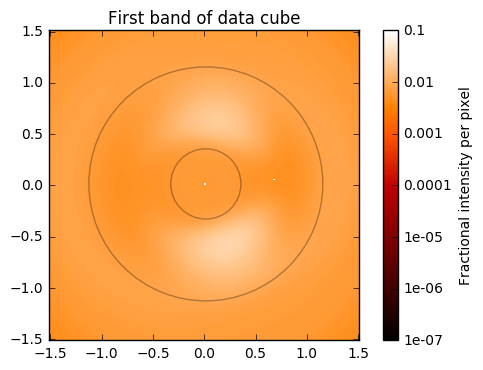

In [14]:
haystacks = fits.open(filename+'proc.fits')

#define adjustable cropping factor
border=1
input_cube = haystacks[0].data[:,border:-border,border:-border]#[:,90:-90,90:-90]#[:2,580:-580,580:-580]

haystacks[0].header["INFITS"] = filename+'proc.fits'
haystacks[0].header["PIXELSCL"] = asec_per_pix
haystacks[0].header["BUNIT"] = "Jy"

#location of center from Ds9 inspection
'''
DS9 coordinate notes, corners are from 0.5-213.5 and center is at 108.

in numpy coordinates the center is at 107,107

'''

center = (107-border)
print(input_cube[:,center,center])

# find parameters:
dim = input_cube.shape

ny = dim[1]
nx = dim[2]
haystacks[0].header



haystack_1stBand = fits.HDUList([fits.PrimaryHDU(input_cube[0],
                                                 header=haystacks[0].header)])
ax=plt.subplot(111)
poppy.display_PSF(haystack_1stBand,
                  interpolation='nearest',ax=ax)
circle2 = plt.Circle((0.015, 0.015), 0.057*6, color='black', fill=False,alpha=0.3)
circle3 = plt.Circle((0.015, 0.015), 0.057*20, color='black', fill=False,alpha=0.3)

ax.add_artist(circle2)
ax.add_artist(circle3)


plt.title("First band of data cube")



In [15]:
contrast_floor=1e-11
# thresh=contrast_floor*input_cube[:,center,center]
thresh=np.zeros(3)
# n_thresh=[cube[np.where(input_cube[i]>thresh[i])].size for i in range(len(thresh))]
print (thresh)

[ 0.  0.  0.]


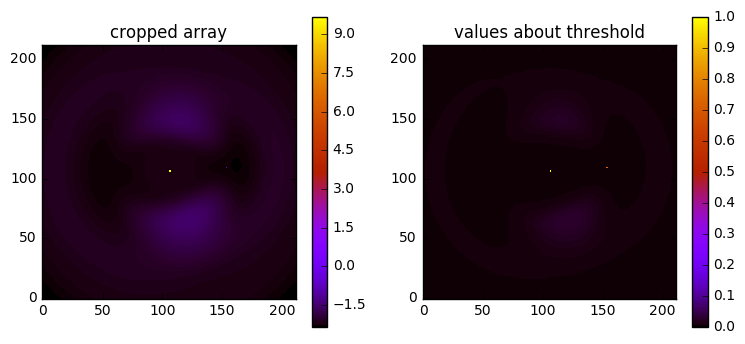

In [16]:
plt.figure(figsize=[9,4])
plt.subplot(121)
plt.title("cropped array")
plt.imshow(np.log10(input_cube[0]),
           cmap=plt.cm.gnuplot,
           origin = 'lower',
           interpolation='nearest')
plt.colorbar()
plt.subplot(122)
plt.title("values about threshold")
plt.imshow(input_cube[0],cmap=plt.cm.gnuplot,
           interpolation='nearest',
           vmin=thresh[0],
           origin = 'lower',vmax=1)
plt.colorbar()


In [17]:
mode_list = ['DISKSPC_F661','DISKSPC_F721','DISKSPC_F883']
lib_list = ['offax_psf_map_DISKSPC_F661.fits.gz','offax_psf_map_DISKSPC_F721.fits.gz','offax_psf_map_DISKSPC_F883.fits.gz']

In [18]:
wavelength_imgs = []
on_axis_psfs=[]


for i in range(len(mode_list)):
    mode = mode_list[i]
    print('Processing mode ' + mode)
    # same scale for all bands
    diskspc = wfirst.CGI(mode=mode, pixelscale=lamoD_asec_F661, fov_arcsec=fov)
    proto_psf = diskspc.calc_psf(display=False, fov_arcsec=fov)
    inputImage = input_cube[i,:,:]
    
    proto_psf[0].data = inputImage[center,center]*proto_psf[0].data
    on_axis_psfs.append(proto_psf)
    
    # load library of PSFs for this filter
    libpsf = fits.getdata(lib_list[i])
    
    outputImage = np.zeros(proto_psf[0].data.shape)
    
    center_lib_psf = 240

    
    # now loop over all relevant pixels
    for x in range(-nx//2,-nx//2+nx):
        for y in range(-ny//2,-ny//2+ny):
#             r = np.sqrt(x**2+y**2)*
#             if inputImage[y+center,x+center] < thresh[i] or (x==0)*(y==0):
#                 continue
            psf = xy_to_psf(x+center_lib_psf//2,y+center_lib_psf//2,libpsf)
            outputImage += inputImage[y+center,x+center]*psf
            
    wavelength_imgs.append(outputImage)
outcube = np.zeros((3,wavelength_imgs[0].shape[0],wavelength_imgs[0].shape[1]))    


Processing mode DISKSPC_F661
Processing mode DISKSPC_F721
Processing mode DISKSPC_F883


In [19]:
for i in range(len(mode_list)):
    outcube[2-i,:,:] = wavelength_imgs[i]            
out = fits.HDUList([fits.PrimaryHDU(data=outcube)])
out.writeto(filename+'final.fits',clobber=True)

In [22]:
cahoy=np.loadtxt('Jup_2AU_3x_Cahoy.txt')

In [23]:
print(cahoy.shape)

(2000, 7)


In [25]:
print (cahoy[:,3])

[  7.27053700e-01   7.27270300e-01   7.27486400e-01 ...,   8.30727000e-02
   8.30753000e-02   5.00000000e-07]


In [32]:
out = np.savetxt('Jup_2AU_3x_Cahoy_formatted.txt',np.array([cahoy[:,1],cahoy[:,3]]).T)